In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### Loading the Data

Convert coordinates into location groups (Ref: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved)

In [2]:
df = pd.read_csv('widsdatathon2023/train_data.csv', parse_dates=['startdate'])

target = 'contest-tmp2m-14d__tmp2m'

df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-27.68,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-21.13,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-10.72,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,0.33,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,9.83,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95


### Visualization

In [3]:
def plot_timeseries_by_region(df, regions, target, x_label, y_label):
    plt.figure(figsize = (10, 6))
    
    for region in regions:
        region_df = df[df['climateregions__climateregion'] == region]
        region_y = region_df[target]
        region_x = region_df['startdate']
        
        plt.plot(region_x, region_y, alpha=0.5, label=region)
        plt.grid()
        plt.legend()
    
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel(y_label, {'fontsize': 12})

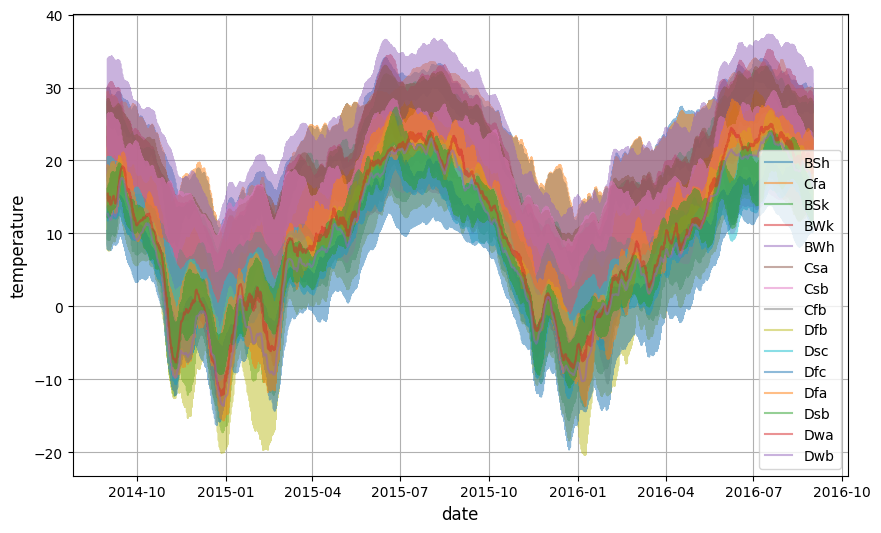

In [4]:
regions = df['climateregions__climateregion'].unique()
df = df.sort_values(by=['startdate'], axis=0)
plot_timeseries_by_region(df, regions,'contest-tmp2m-14d__tmp2m', 'date', 'temperature')

### Preprocessing

In [5]:
scale = 14

df.loc[:, 'lat'] = round(df.lat, scale)
df.loc[:, 'lon'] = round(df.lon, scale)

# Create new feature
df['loc_group'] = df.groupby(['lat','lon']).ngroup().astype('string')

print(f'{df.loc_group.nunique()} unique locations')

# remove lat and lon
df.drop(['lat', 'lon'], axis=1, inplace=True)

514 unique locations


In [6]:
df.head()

,index,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,0,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,31.52,31.68,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.5,11.9,4.58,0
290938,290938,2014-09-01,323.63,24.18,26.75,21.09,23.43,21.15,24.08,23.95,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.5,11.9,4.58,398
35819,35819,2014-09-01,385.92,31.16,32.19,33.26,29.80,28.08,33.64,33.73,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.5,11.9,4.58,49
290207,290207,2014-09-01,303.36,23.34,25.66,20.46,23.00,21.76,24.03,23.92,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.5,11.9,4.58,397
289476,289476,2014-09-01,319.97,22.50,24.57,19.67,22.34,21.61,21.83,21.65,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.5,11.9,4.58,396


One hot encode the unique locations

Impute 7/8 missing values (Ref: https://www.kaggle.com/code/ducnh279/find-x-correctly-impute-7-8-missing-value-columns)

In [7]:
#check for null values
na_df = df.isnull().sum()
na_df.loc[lambda x: x > 0]

nmme0-tmp2m-34w__ccsm30    15934
nmme-tmp2m-56w__ccsm3      10280
nmme-prate-34w__ccsm3       8738
nmme0-prate-56w__ccsm30    15934
nmme0-prate-34w__ccsm30    15934
nmme-prate-56w__ccsm3      10280
nmme-tmp2m-34w__ccsm3       8738
ccsm30                     15934
dtype: int64

In [8]:
na_cols = [
    'nmme0-tmp2m-34w__ccsm30', 
    'nmme-tmp2m-56w__ccsm3', 
    'nmme-prate-34w__ccsm3', 
    'nmme0-prate-56w__ccsm30', 
    'nmme0-prate-34w__ccsm30', 
    'nmme-prate-56w__ccsm3', 
    'nmme-tmp2m-34w__ccsm3'
]

g_means =  [
    'nmme0-tmp2m-34w__nmme0mean', 
    'nmme-tmp2m-56w__nmmemean', 
    'nmme-prate-34w__nmmemean', 
    'nmme0-prate-56w__nmme0mean', 
    'nmme0-prate-34w__nmme0mean', 
    'nmme-prate-56w__nmmemean', 
    'nmme-tmp2m-34w__nmmemean'
]


g_1 = [
    'nmme0-tmp2m-34w__cancm30',
    'nmme0-tmp2m-34w__cancm40',
    'nmme0-tmp2m-34w__ccsm40',
    'nmme0-tmp2m-34w__cfsv20',
    'nmme0-tmp2m-34w__gfdlflora0',
    'nmme0-tmp2m-34w__gfdlflorb0',
    'nmme0-tmp2m-34w__gfdl0',
    'nmme0-tmp2m-34w__nasa0'
]

g_2 = [
    'nmme-tmp2m-56w__cancm3',
    'nmme-tmp2m-56w__cancm4',
    'nmme-tmp2m-56w__ccsm4',
    'nmme-tmp2m-56w__cfsv2',
    'nmme-tmp2m-56w__gfdl',
    'nmme-tmp2m-56w__gfdlflora',
    'nmme-tmp2m-56w__gfdlflorb',
    'nmme-tmp2m-56w__nasa'
]

g_3 = [
    'nmme-prate-34w__cancm3',
    'nmme-prate-34w__cancm4',
    'nmme-prate-34w__ccsm4',
    'nmme-prate-34w__cfsv2',
    'nmme-prate-34w__gfdl',
    'nmme-prate-34w__gfdlflora',
    'nmme-prate-34w__gfdlflorb',
    'nmme-prate-34w__nasa'
]

g_4 = [
    'nmme0-prate-56w__cancm30',
    'nmme0-prate-56w__cancm40',
    'nmme0-prate-56w__ccsm40',
    'nmme0-prate-56w__cfsv20',
    'nmme0-prate-56w__gfdlflora0',
    'nmme0-prate-56w__gfdlflorb0',
    'nmme0-prate-56w__gfdl0',
    'nmme0-prate-56w__nasa0'
]

g_5 = [
    'nmme0-prate-34w__cancm30',
    'nmme0-prate-34w__cancm40',
    'nmme0-prate-34w__ccsm40',
    'nmme0-prate-34w__cfsv20',
    'nmme0-prate-34w__gfdlflora0',
    'nmme0-prate-34w__gfdlflorb0',
    'nmme0-prate-34w__gfdl0',
    'nmme0-prate-34w__nasa0'
]

g_6 = [
    'nmme-prate-56w__cancm3',
    'nmme-prate-56w__cancm4',
    'nmme-prate-56w__ccsm4',
    'nmme-prate-56w__cfsv2',
    'nmme-prate-56w__gfdl',
    'nmme-prate-56w__gfdlflora',
    'nmme-prate-56w__gfdlflorb',
    'nmme-prate-56w__nasa'
]

g_7 = [
    'nmme-tmp2m-34w__cancm3',
    'nmme-tmp2m-34w__cancm4',
    'nmme-tmp2m-34w__ccsm4',
    'nmme-tmp2m-34w__cfsv2',
    'nmme-tmp2m-34w__gfdl',
    'nmme-tmp2m-34w__gfdlflora',
    'nmme-tmp2m-34w__gfdlflorb',
    'nmme-tmp2m-34w__nasa'
]

Impute the feature columns with na values

In [9]:
g_lst = [g_1, g_2, g_3, g_4, g_5, g_6, g_7]

zip_cols = zip(na_cols, g_lst, g_means)
for c, g, m in zip_cols:
    df[c] = (df[m]*9) - df[g].sum(1)

In [10]:
na_df = df.isnull().sum()
na_df.loc[lambda x: x > 0]

ccsm30    15934
dtype: int64

In [11]:
df = df.drop('ccsm30', axis=1)

In [12]:
#separate target from features and remove unnecessary columns
cols_to_drop = ['index', 'startdate', target]

features = [col for col in df.columns if col not in cols_to_drop]
X_df = df[features]
y_df = df[target]

In [13]:
# one hot encode location groups
loc_group = pd.get_dummies(X_df['loc_group'])
X_df = pd.concat([X_df, loc_group], axis=1)
X_df.drop('loc_group', axis=1, inplace=True)

Convert 3-4 week and 5-6 week variables to be within 14 days (Ref: TODO)

One Hot Encode climate regions

In [14]:
# one hot encode climate regions
climate_regions = pd.get_dummies(X_df['climateregions__climateregion'])
X_df = pd.concat([X_df, climate_regions], axis=1)
X_df.drop('climateregions__climateregion', axis=1, inplace=True)

In [15]:
nmme_tm2m_34w_features = X_df.columns[X_df.columns.str.startswith('nmme0-tmp2m-34w')].tolist()
nmme_tm2m_56w_features = X_df.columns[X_df.columns.str.startswith('nmme-tmp2m-56w')].tolist()

# 4 * 7 = 28 so shifting by -14 brings us to 14 days
X_df[nmme_tm2m_34w_features] = X_df[nmme_tm2m_34w_features].shift(-14).ffill()

# 6 * 7 = 42 so shifting by -28 brings us to 14 days
X_df[nmme_tm2m_56w_features] = X_df[nmme_tm2m_34w_features].shift(-28).ffill()

In [16]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=0)

In [17]:
X_scaler = MinMaxScaler()

# standardize the data
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(251741, 768)
(251741,)
(123993, 768)
(123993,)


In [24]:
#loss with relu activation
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1)
    ])
    
    model.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(0.001),
                 metrics=['RootMeanSquaredError'])
    
    return model

In [25]:
model = build_model()

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

2023-03-18 17:13:18.788877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-18 17:13:18.789620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2
Epoch 1/20


2023-03-18 17:13:19.593317: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  13/7867 [..............................] - ETA: 34s - loss: 126.7540 - root_mean_squared_error: 11.2585  

2023-03-18 17:13:19.805140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7867/7867 [==============================] - ETA: 0s - loss: 1.6248 - root_mean_squared_error: 1.2747

2023-03-18 17:13:53.120520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7867/7867 [==============================] - 42s 5ms/step - loss: 1.6248 - root_mean_squared_error: 1.2747 - val_loss: 0.4395 - val_root_mean_squared_error: 0.6629
Epoch 2/20
7867/7867 [==============================] - 50s 6ms/step - loss: 0.4280 - root_mean_squared_error: 0.6543 - val_loss: 0.3050 - val_root_mean_squared_error: 0.5523
Epoch 3/20
7867/7867 [==============================] - 40s 5ms/step - loss: 0.3084 - root_mean_squared_error: 0.5554 - val_loss: 0.2422 - val_root_mean_squared_error: 0.4922
Epoch 4/20
7867/7867 [==============================] - 39s 5ms/step - loss: 0.2456 - root_mean_squared_error: 0.4956 - val_loss: 0.1923 - val_root_mean_squared_error: 0.4385
Epoch 5/20
7867/7867 [==============================] - 39s 5ms/step - loss: 0.2048 - root_mean_squared_error: 0.4526 - val_loss: 0.2306 - val_root_mean_squared_error: 0.4802
Epoch 6/20
7867/7867 [==============================] - 39s 5ms/step - loss: 0.1803 - root_mean_squared_error: 0.4246 - val_loss: 0.2034

In [26]:
y_pred = model.predict(X_test)

 133/3875 [>.............................] - ETA: 4s

2023-03-18 17:26:47.246419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3875/3875 [==============================] - 4s 1ms/step


In [27]:
y_test

array([27.96264008, -6.59673734, 11.33674717, ...,  7.23453552,
        5.54445786,  2.98357452])

In [28]:
y_pred

array([[27.704433 ],
       [-6.5653944],
       [11.3547735],
       ...,
       [ 7.4894495],
       [ 5.2273455],
       [ 3.3179042]], dtype=float32)

In [29]:
#testing loss with linear activation
def build_model2():
    model = keras.Sequential([
        keras.layers.Dense(256, activation='linear'),
        keras.layers.Dense(256, activation='linear'),
        keras.layers.Dense(1)
    ])
    
    model.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(0.001),
                 metrics=['RootMeanSquaredError'])
    
    return model

In [30]:
m2 = build_model2()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=2,
                                                mode='min')

m2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
  26/7867 [..............................] - ETA: 32s - loss: 72.3832 - root_mean_squared_error: 8.5078   

2023-03-18 17:26:53.217324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7864/7867 [============================>.] - ETA: 0s - loss: 2.0616 - root_mean_squared_error: 1.4358

2023-03-18 17:27:24.802317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7867/7867 [==============================] - 39s 5ms/step - loss: 2.0613 - root_mean_squared_error: 1.4357 - val_loss: 1.1666 - val_root_mean_squared_error: 1.0801
Epoch 2/20
7867/7867 [==============================] - 39s 5ms/step - loss: 1.2744 - root_mean_squared_error: 1.1289 - val_loss: 1.1175 - val_root_mean_squared_error: 1.0571
Epoch 3/20
7867/7867 [==============================] - 40s 5ms/step - loss: 1.2072 - root_mean_squared_error: 1.0987 - val_loss: 1.1458 - val_root_mean_squared_error: 1.0704
Epoch 4/20
7867/7867 [==============================] - 39s 5ms/step - loss: 1.1548 - root_mean_squared_error: 1.0746 - val_loss: 1.2712 - val_root_mean_squared_error: 1.1275


In [31]:
m2.predict(X_test)

 141/3875 [>.............................] - ETA: 4s

2023-03-18 17:29:31.197831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3875/3875 [==============================] - 4s 1ms/step


array([[27.16119  ],
       [-5.1161466],
       [ 9.380339 ],
       ...,
       [ 8.353188 ],
       [ 4.4532046],
       [ 3.771752 ]], dtype=float32)

In [32]:
y_test

array([27.96264008, -6.59673734, 11.33674717, ...,  7.23453552,
        5.54445786,  2.98357452])

In [33]:
#try lasso regression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [34]:
m3 = Lasso(alpha = 0.05)

m3.fit(X_train, y_train)

Lasso(alpha=0.05)

In [35]:
y_pred = m3.predict(X_test)
y_pred

array([27.04099863, -5.37978116,  9.74510518, ..., 10.34718869,
        2.23692354,  5.44499078])

In [36]:
rsme = mean_squared_error(y_test, y_pred, squared=False)
print(f'RSME: {rsme}')

RSME: 1.9555213191467296


### Training on the entire dataset using the first model

In [37]:
all_X = X_scaler.transform(X_df)
all_y = y_df.to_numpy()

final_model = build_model()

In [38]:
final_model.fit(all_X, all_y, epochs=20) 

Epoch 1/20
   26/11742 [..............................] - ETA: 50s - loss: 106.2241 - root_mean_squared_error: 10.3065 

2023-03-18 17:30:45.033208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11742/11742 [==============================] - 49s 4ms/step - loss: 1.3018 - root_mean_squared_error: 1.1410
Epoch 2/20
11742/11742 [==============================] - 48s 4ms/step - loss: 0.3379 - root_mean_squared_error: 0.5813
Epoch 3/20
11742/11742 [==============================] - 48s 4ms/step - loss: 0.2348 - root_mean_squared_error: 0.4846
Epoch 4/20
11742/11742 [==============================] - 48s 4ms/step - loss: 0.1889 - root_mean_squared_error: 0.4347
Epoch 5/20
11742/11742 [==============================] - 48s 4ms/step - loss: 0.1579 - root_mean_squared_error: 0.3973
Epoch 6/20
11742/11742 [==============================] - 49s 4ms/step - loss: 0.1358 - root_mean_squared_error: 0.3686
Epoch 7/20
11742/11742 [==============================] - 48s 4ms/step - loss: 0.1219 - root_mean_squared_error: 0.3491
Epoch 8/20
11742/11742 [==============================] - 49s 4ms/step - loss: 0.1094 - root_mean_squared_error: 0.3307
Epoch 9/20
11742/11742 [===========================

### Submission Preparation

In [39]:
test_df = pd.read_csv('widsdatathon2023/test_data.csv', parse_dates=['startdate'])

target = 'contest-tmp2m-14d__tmp2m'

df.head()

,index,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,0,2014-09-01,237.00,29.02,31.64,29.62,30.73,29.71,31.52,31.68,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.5,11.9,4.58,0
290938,290938,2014-09-01,323.63,24.18,26.75,21.04,23.43,21.15,24.08,23.95,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.5,11.9,4.58,398
35819,35819,2014-09-01,385.92,31.16,32.19,33.29,29.80,28.08,33.64,33.73,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.5,11.9,4.58,49
290207,290207,2014-09-01,303.36,23.34,25.66,20.50,23.00,21.76,24.03,23.92,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.5,11.9,4.58,397
289476,289476,2014-09-01,319.97,22.50,24.57,19.66,22.34,21.61,21.83,21.65,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.5,11.9,4.58,396


In [40]:
scale = 14

test_df.loc[:, 'lat'] = round(test_df.lat, scale)
test_df.loc[:, 'lon'] = round(test_df.lon, scale)

# Create new feature
test_df['loc_group'] = test_df.groupby(['lat','lon']).ngroup().astype('string')

print(f'{test_df.loc_group.nunique()} unique locations')

# remove lat and lon
test_df.drop(['lat', 'lon'], axis=1, inplace=True)

514 unique locations


In [41]:
test_df.head()

,index,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,375734,2022-11-01,339.88,30.88,30.92,29.17,31.02,29.47,30.93,30.54,...,-39.77,-29.25,40.88,-8.31,14.91,-24.62,31.05,-23.69,6.27,0
1,375735,2022-11-02,334.63,30.88,30.92,29.17,31.02,29.47,30.93,30.54,...,-43.14,-28.62,45.37,-5.42,16.97,-23.94,28.84,-20.61,14.16,0
2,375736,2022-11-03,337.83,30.88,30.92,29.17,31.02,29.47,30.93,30.54,...,-44.22,-27.67,49.76,-1.31,21.44,-19.06,26.85,-16.78,13.42,0
3,375737,2022-11-04,345.81,30.88,30.92,29.17,31.02,29.47,30.93,30.54,...,-49.47,-19.32,52.62,-0.44,21.65,-23.12,23.70,-18.62,10.69,0
4,375738,2022-11-05,357.39,30.88,30.92,29.17,31.02,29.47,30.93,30.54,...,-56.07,-9.89,51.23,-7.57,19.86,-30.56,20.66,-25.08,19.64,0


In [42]:
#separate target from features and remove unnecessary columns
cols_to_drop = ['index', 'startdate', 'ccsm30']

features = [col for col in test_df.columns if col not in cols_to_drop]
X_test_df = test_df[features]

In [43]:
# one hot encode location groups
loc_group = pd.get_dummies(X_test_df['loc_group'])
X_test_df = pd.concat([X_test_df, loc_group], axis=1)
X_test_df.drop('loc_group', axis=1, inplace=True)

Convert 3-4 week and 5-6 week variables to be within 14 days (Ref: TODO)

One Hot Encode climate regions

In [44]:
# one hot encode climate regions
climate_regions = pd.get_dummies(X_test_df['climateregions__climateregion'])
X_test_df = pd.concat([X_test_df, climate_regions], axis=1)
X_test_df.drop('climateregions__climateregion', axis=1, inplace=True)

In [45]:
nmme_tm2m_34w_features = X_test_df.columns[X_test_df.columns.str.startswith('nmme0-tmp2m-34w')].tolist()
nmme_tm2m_56w_features = X_test_df.columns[X_test_df.columns.str.startswith('nmme-tmp2m-56w')].tolist()

# 4 * 7 = 28 so shifting by -14 brings us to 14 days
X_test_df[nmme_tm2m_34w_features] = X_test_df[nmme_tm2m_34w_features].shift(-14).ffill()

# 6 * 7 = 42 so shifting by -28 brings us to 14 days
X_test_df[nmme_tm2m_56w_features] = X_test_df[nmme_tm2m_34w_features].shift(-28).ffill()

In [46]:
X_test_df.head()

,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,...,Cfb,Csa,Csb,Dfa,Dfb,Dfc,Dsb,Dsc,Dwa,Dwb
0,339.88,30.88,30.92,29.17,31.02,29.47,30.93,30.54,31.01,29.39,...,0,0,0,0,0,0,0,0,0,0
1,334.63,30.88,30.92,29.17,31.02,29.47,30.93,30.54,31.01,29.39,...,0,0,0,0,0,0,0,0,0,0
2,337.83,30.88,30.92,29.17,31.02,29.47,30.93,30.54,31.01,29.39,...,0,0,0,0,0,0,0,0,0,0
3,345.81,30.88,30.92,29.17,31.02,29.47,30.93,30.54,31.01,29.39,...,0,0,0,0,0,0,0,0,0,0
4,357.39,30.88,30.92,29.17,31.02,29.47,30.93,30.54,31.01,29.39,...,0,0,0,0,0,0,0,0,0,0


In [47]:
X_sub = X_scaler.transform(X_test_df)

In [48]:
y_pred_sub = final_model.predict(X_sub)

122/980 [==>...........................] - ETA: 1s

2023-03-18 17:46:48.684783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


980/980 [==============================] - 1s 1ms/step


In [49]:
test_df[target] = y_pred_sub

In [50]:
test_df[[target, 'index']].to_csv('submission.csv', index=False)

In [51]:
test_df[[target, 'index']].shape

(31354, 2)